# Week 5: CNN-1

## 实验准备
* 熟悉python语言的使用和numpy,torch的基本用法
* 熟悉神经网络的训练过程与优化方法
* 结合理论课的内容,了解卷积与卷积神经网络(CNN)的内容和原理
* 了解常用的CNN模型的基本结构,如AlexNet,Vgg,ResNet



## 实验过程
### 1. 卷积与卷积层

- numpy实现卷积
- pytorch中的卷积层和池化层

### 2. CNN

- 实现并训练一个基本的CNN网络
- ResNet
- VGG

### 卷积

![conv](pics/conv2d.gif)

在实验课上我们已经了解过卷积运算的操作当我们对一张二维的图像做卷积时,将卷积核沿着图像进行滑动乘加即可(如上图所示).


下面的conv函数实现了对二维**单通道**图像的卷积.考虑输入的卷积核kernel的长宽相同,padding为对图像的四个边缘补0,stride为卷积核窗口滑动的步长.

In [1]:
import numpy as np

def convolution(img, kernel, padding=1, stride=1):
    """
    img: input image with one channel
    kernel: convolution kernel
    """
    
    h, w = img.shape
    kernel_size = kernel.shape[0]
    
    # height and width of image with padding 
    ph, pw = h + 2 * padding, w + 2 * padding
    padding_img = np.zeros((ph, pw))
    padding_img[padding:h + padding, padding:w + padding] = img
    
    # height and width of output image
    result_h = (h + 2 * padding - kernel_size) // stride + 1
    result_w = (w + 2 * padding - kernel_size) // stride + 1
    
    result = np.zeros((result_h, result_w))
    
    # convolution
    x, y = 0, 0
    for i in range(0, ph - kernel_size + 1, stride):
        for j in range(0, pw - kernel_size + 1, stride):
            roi = padding_img[i:i+kernel_size, j:j+kernel_size]
            result[x, y] = np.sum(roi * kernel)
            y += 1
        y = 0
        x += 1
    return result

下面在图像上简单一下测试我们的conv函数,这里使用3\*3的高斯核对下面的图像进行滤波.
![lena](pics/lena.jpg)

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('pics/lena.jpg').convert('L')
plt.imshow(img, cmap='gray')

Text(0.5, 1.0, 'gauss kernel_size=5')

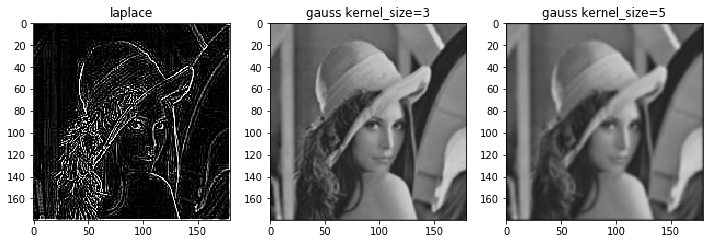

In [3]:
#  a Laplace kernel
laplace_kernel = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]])

# Gauss kernel with kernel_size=3
gauss_kernel3 = (1/ 16) * np.array([[1, 2, 1], 
                                   [2, 4, 2], 
                                   [1, 2, 1]])

# Gauss kernel with kernel_size=5
gauss_kernel5 = (1/ 84) * np.array([[1, 2, 3, 2, 1],
                                    [2, 5, 6, 5, 2], 
                                    [3, 6, 8, 6, 3],
                                    [2, 5, 6, 5, 2],
                                    [1, 2, 3, 2, 1]])

fig, ax = plt.subplots(1, 3, figsize=(12, 8))

laplace_img = convolution(np.array(img), laplace_kernel, padding=1, stride=1)
ax[0].imshow(Image.fromarray(laplace_img), cmap='gray')
ax[0].set_title('laplace')

gauss3_img = convolution(np.array(img), gauss_kernel3, padding=1, stride=1)
ax[1].imshow(Image.fromarray(gauss3_img), cmap='gray')
ax[1].set_title('gauss kernel_size=3')

gauss5_img = convolution(np.array(img), gauss_kernel5, padding=2, stride=1)
ax[2].imshow(Image.fromarray(gauss5_img), cmap='gray')
ax[2].set_title('gauss kernel_size=5')

上面我们实现了实现了对单通道输入单通道输出的卷积.在CNN中,一般使用到的都是多通道输入多通道输出的卷积,要实现多通道的卷积, 我们只需要对循环调用上面的conv函数即可.

In [4]:
def myconv2d(features, weights,  padding=0, stride=1):
    """
    features: input, in_channel * h * w
    weights: kernel, out_channel * in_channel * kernel_size * kernel_size
    return output with out_channel
    """
    in_channel, h, w = features.shape
    out_channel, _, kernel_size, _ = weights.shape
    
    # height and width of output image
    output_h = (h + 2 * padding - kernel_size) // stride + 1
    output_w = (w + 2 * padding - kernel_size) // stride + 1
    output = np.zeros((out_channel, output_h, output_w))
    
    # call convolution out_channel * in_channel times
    for i in range(out_channel):
        weight = weights[i]
        for j in range(in_channel):
            feature_map = features[j]
            kernel = weight[j]
            output[i] += convolution(feature_map, kernel, padding, stride)
    return output

接下来, 让我们测试我们写好的myconv2d函数.

In [5]:
input_data=[
           [[0,0,2,2,0,1],
            [0,2,2,0,0,2],
            [1,1,0,2,0,0],
            [2,2,1,1,0,0],
            [2,0,1,2,0,1],
            [2,0,2,1,0,1]],

           [[2,0,2,1,1,1],
            [0,1,0,0,2,2],
            [1,0,0,2,1,0],
            [1,1,1,1,1,1],
            [1,0,1,1,1,2],
            [2,1,2,1,0,2]]
            ]
weights_data=[[ 
               [[ 0, 1, 0],
                [ 1, 1, 1],
                [ 0, 1, 0]],
    
               [[-1, -1, -1],
                [ -1, 8, -1],
                [ -1, -1, -1]] 
           ]]

# numpy array
input_data   = np.array(input_data)
weights_data = np.array(weights_data)

# show the result
print(myconv2d(input_data, weights_data, padding=3, stride=3))

[[[ 0.  0.  0.  0.]
  [ 0.  8. 10.  0.]
  [ 0. -5.  2.  0.]
  [ 0.  0.  0.  0.]]]


在Pytorch中,已经为我们提供了卷积和卷积层的实现.使用同样的input和weights,以及stride,padding,pytorch的卷积的结果应该和我们的一样.可以在下面的代码中进行验证.

In [6]:
import torch
import torch.nn.functional as F
input_tensor = torch.tensor(input_data).unsqueeze(0).float()

F.conv2d(input_tensor, weight=torch.tensor(weights_data).float(), bias=None, stride=3, padding=3)


tensor([[[[ 0.,  0.,  0.,  0.],
          [ 0.,  8., 10.,  0.],
          [ 0., -5.,  2.,  0.],
          [ 0.,  0.,  0.,  0.]]]])

#### 作业:
上述代码中convolution的实现只考虑卷积核以及padding和stride长宽一致的情况,若输入的卷积核可能长宽不一致,padding与stride的输入可能为两个元素的元祖(代表两个维度上的padding与stride)并使用下面test input对你的convolutionV2进行测试.

In [7]:
def convolutionV2(img, kernel, padding=(0,0), stride=(1,1)):
    # To-Do
    h, w = img.shape
    kernel_size_h, kernel_size_w = kernel.shape
    
    # height and width of image with padding 
    ph, pw = h + 2 * padding[0], w + 2 * padding[1]
    padding_img = np.zeros((ph, pw))
    padding_img[padding[0]:h + padding[0], padding[1]:w + padding[1]] = img
    
    # height and width of output image
    result_h = (h + 2 * padding[0] - kernel_size_h) // stride[0] + 1
    result_w = (w + 2 * padding[1] - kernel_size_w) // stride[1] + 1
    
    result = np.zeros((result_h, result_w))
    
    # convolution
    x, y = 0, 0
    for i in range(0, ph - kernel_size_h + 1, stride[0]):
        for j in range(0, pw - kernel_size_w + 1, stride[1]):
            roi = padding_img[i:i+kernel_size_h, j:j+kernel_size_w]
            result[x, y] = np.sum(roi * kernel)
            y += 1
        y = 0
        x += 1
    return result

In [8]:
# test input
test_input = np.array([[1, 1, 2, 1],
                       [0, 1, 0, 2],
                       [2, 2, 0, 2],
                       [2, 2, 2, 1],
                       [2, 3, 2, 3]])

test_kernel = np.array([[1, 0], [0, 1], [0, 0]])

# output
print(convolutionV2(test_input, test_kernel, padding=(1, 0), stride=(1, 1)))

print(convolutionV2(test_input, test_kernel, padding=(2, 1), stride=(1, 2)))

[[1. 2. 1.]
 [2. 1. 4.]
 [2. 1. 2.]
 [4. 4. 1.]
 [5. 4. 5.]]
[[0. 0. 0.]
 [1. 2. 0.]
 [0. 1. 1.]
 [2. 1. 2.]
 [2. 4. 2.]
 [2. 4. 1.]
 [0. 3. 3.]]


### 卷积层
Pytorch提供了卷积层和池化层供我们使用.

卷积层与上面相似, 而池化层与卷积层相似,Pooling layer的主要目的是缩小features的size.常用的有MaxPool(滑动窗口取最大值)与AvgPool(滑动窗口取均值)

In [9]:
import torch
import torch.nn as nn


x = torch.randn(1, 1, 32, 32)

conv_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=2, padding=2)
y = conv_layer(x)
print(x.shape)
print(y.shape)

torch.Size([1, 1, 32, 32])
torch.Size([1, 3, 16, 16])


**请问**:
1. 输入与输出的tensor的size分别是多少?该卷积层的参数量是多少?
2. 若kernel_size=5,stride=2,padding=2, 输出的tensor的size是多少?在上述代码中改变参数后试验后并回答.
3. 若输入的tensor size为N\*C\*H\*W,若第5行中卷积层的参数为in_channels=C,out_channels=Cout,kernel_size=k,stride=s,padding=p,那么输出的tensor size是多少? 

**答**: 
- 输入的tensor的size是1$\times$1$\times$32$\times$32，输出的tensor的size是1$\times$3$\times$30$\times$30；该卷积层的参数量是1$\times$3$\times$3$\times$3+3 = 30。
- 输出的tensor的size是1$\times$3$\times$16$\times$16。
- 输出的tensor size是N$\times$Cout$\times$((H+2$\times$p-k)//s+1)$\times$((W+2$\times$p-k)//s+1)

In [10]:
# input N * C * H * W
x = torch.randn(1, 1, 4, 4)

# maxpool
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
y = maxpool(x)

# avgpool
avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
z = avgpool(x)

#avgpool
print(x.shape)
print(y.shape)
print(z.shape)
print(x)
print(y)
print(z)

torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
tensor([[[[ 1.6408,  1.3070,  0.1300,  0.9228],
          [-2.4545,  0.3913,  0.2290,  1.4280],
          [-0.0806, -0.6845, -1.9326,  0.9075],
          [ 1.4387,  0.2554,  0.5753, -1.6588]]]])
tensor([[[[1.6408, 1.4280],
          [1.4387, 0.9075]]]])
tensor([[[[ 0.2212,  0.6774],
          [ 0.2323, -0.5271]]]])


### GPU
我们可以选择在cpu或gpu上来训练我们的模型.   
实验室提供了4卡的gpu服务器,要查看各个gpu设备的使用情况,可以在服务器上的jupyter主页点击new->terminal,在terminal中输入nvidia-smi即可查看每张卡的使用情况.如下图.
![nvidia-smi](pics/nvidia-smi.png)
上图左边一栏显示了他们的设备id(0,1,2,3),风扇转速,温度,性能状态,能耗等信息,中间一栏显示他们的bus-id和显存使用量,右边一栏是GPU使用率等信息.注意到中间一栏的显存使用量,在训练模型前我们可以根据空余的显存来选择我们使用的gpu设备.   
在本次实验中我们将代码中的torch.device('cuda:0')的0更换成所需的设备id即可选择在相应的gpu设备上运行程序.

## CNN(卷积神经网络)


### 一个简单的CNN

接下来,让我们建立一个简单的CNN分类器.
这个CNN的整体流程是    
卷积(Conv2d) -> BN(batch normalization) -> 激励函数(ReLU) -> 池化(MaxPooling) ->     
卷积(Conv2d) -> BN(batch normalization) -> 激励函数(ReLU) -> 池化(MaxPooling) ->    
全连接层(Linear) -> 输出.

In [11]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision


class MyCNN(nn.Module):
    
    def __init__(self, image_size, num_classes):
        super(MyCNN, self).__init__()
        # conv1: Conv2d -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # conv2: Conv2d -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected layer
        self.fc = nn.Linear(32 * (image_size // 4) * (image_size // 4), num_classes)
        

    def forward(self, x):
        """
        input: N * 3 * image_size * image_size
        output: N * num_classes
        """
        x = self.conv1(x)
        x = self.conv2(x)
        # view(x.size(0), -1): change tensor size from (N ,C, H , W) to (N, C*H*W)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output

这样,一个简单的CNN模型就写好了.与前面的课堂内容相似,我们需要对完成网络进行训练与评估的代码.

In [12]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every 100 iteration, print loss
        if (i + 1) % 100 == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [13]:
def evaluate(model, val_loader, device):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model变成测试模式
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            
            
            outputs = model(images)
            
            # return the maximum value of each row of the input tensor in the 
            # given dimension dim, the second return vale is the index location
            # of each maxium value found(argmax)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            correct += (predicted == targets).sum().item()
            
            total += targets.size(0)
            
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        return accuracy

In [14]:
def save_model(model, save_path):
    # save model
    torch.save(model.state_dict(), save_path)

In [15]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

#### 准备数据与训练模型
接下来，我们使用CIFAR10数据集来对我们的CNN模型进行训练.

CIFAR-10:该数据集共有60000张彩色图像,这些图像是32\*32,分为10个类,每类6000张图.这里面有50000张用于训练,构成了5个训练批,每一批10000张图;另外10000用于测试,单独构成一批.在本次实验中,使用CIFAR-10数据集来训练我们的模型.我们可以用torchvision.datasets.CIFAR10来直接使用CIFAR10数据集.   


为了减少训练时间以及降低传输时间,我们在这里提供了一个删减版的CIFAR10,训练集共10000张(每类1000张),测试集5000张(每类500张).当然你也可以选择使用完整版的CIFAR10数据集(需要下载)进行训练.
![cifar10](pics/cifar10.png)

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# mean and std of cifar10 in 3 channels 
cifar10_mean = (0.49, 0.48, 0.45)
cifar10_std = (0.25, 0.24, 0.26)

# define transform operations of train dataset 
train_transform = transforms.Compose([
    # data augmentation
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)])

# mini train Cifar10 datasets: 1000 images each class
train_dataset = torchvision.datasets.ImageFolder(root='./data/path2cifar10/train', transform=train_transform)
# mini test Cifar10 datasets: 500 images each class
test_dataset = torchvision.datasets.ImageFolder(root='./data/path2cifar10/test', transform=test_transform)

"""
torchvision.datasets provide the full version of CIFAR-10 dataset
if you want to train the full version of cifar10 datasets, use codes below instead.
""" 
# train_dataset = torchvision.datasets.CIFAR10(root='./data/',
#                                              train=True, 
#                                              transform=train_transform,
#                                              download=True)
# test_dataset = torchvision.datasets.CIFAR10(root='./data/',
#                                             train=False, 
#                                             transform=test_transform)

# Data loader: provides single- or multi-process iterators over the dataset.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

训练过程中使用交叉熵(cross-entropy)损失函数与Adam优化器来训练我们的分类器网络.
阅读下面的代码并在To-Do处,根据之前所学的知识,补充前向传播和反向传播的代码来实现分类网络的训练.

In [17]:
def fit(model, num_epochs, optimizer, device):
    """
    train and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function
    """
        
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
    
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [22]:
# hyper parameters
num_epochs = 10
lr = 0.01
image_size = 32
num_classes = 10

In [23]:
# declare and define an objet of MyCNN
mycnn = MyCNN(image_size, num_classes)
print(mycnn)

MyCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)


Epoch 1/10:
Step [100/100] Train Loss: 1.7490
Accuracy on Test Set: 39.9800 %
Epoch 2/10:
Step [100/100] Train Loss: 1.7038
Accuracy on Test Set: 42.0400 %
Epoch 3/10:
Step [100/100] Train Loss: 1.7163
Accuracy on Test Set: 48.9600 %
Epoch 4/10:
Step [100/100] Train Loss: 1.6252
Accuracy on Test Set: 49.3800 %
Epoch 5/10:
Step [100/100] Train Loss: 1.4477
Accuracy on Test Set: 50.1400 %
Epoch 6/10:
Step [100/100] Train Loss: 1.4038
Accuracy on Test Set: 52.2000 %
Epoch 7/10:
Step [100/100] Train Loss: 1.4380
Accuracy on Test Set: 54.6600 %
Epoch 8/10:
Step [100/100] Train Loss: 1.3672
Accuracy on Test Set: 53.0000 %
Epoch 9/10:
Step [100/100] Train Loss: 1.3539
Accuracy on Test Set: 59.2000 %
Epoch 10/10:
Step [100/100] Train Loss: 1.5146
Accuracy on Test Set: 56.5800 %


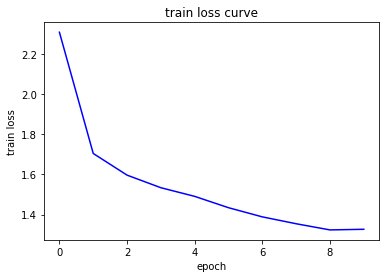

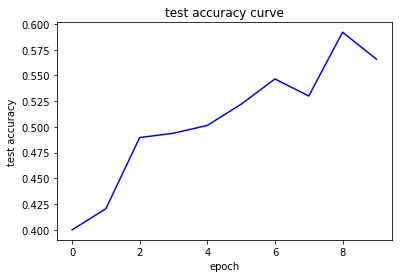

In [24]:
# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:0')

optimizer = torch.optim.Adam(mycnn.parameters(), lr=lr)

# start training on cifar10 dataset
fit(mycnn, num_epochs, optimizer, device)

#### ResNet
接下来,让我们完成更复杂的CNN的实现.  
ResNet又叫做残差网络.在ResNet网络结构中会用到两种残差模块，一种是以两个3\*3的卷积网络串接在一起作为一个残差模块，另外一种是1\*1、3\*3、1\*1的3个卷积网络串接在一起作为一个残差模块。他们如下图所示。
![ResNet](pics/block.png)
我们以左边的模块为例实现一个ResidualBlock.注意到由于我们在两次卷积中可能会使输入的tensor的size与输出的tensor的size不相等,为了使它们能够相加,所以输出的tensor与输入的tensor size不同时,我们使用downsample(由外部传入)来使保持size相同

现在,试在**To-Do补充代码**完成下面的forward函数来完成ResidualBlock的实现,并运行它.

In [25]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        """
        Defines the computation performed at every call.
        x: N * C * H * W
        """
        residual = x
        # if the size of input x changes, using downsample to change the size of residual
        if self.downsample:
            residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        
        
        """
        To-Do: add code here
        """
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)
        return out

下面是一份针对cifar10数据集的ResNet的实现.   
它先通过一个conv3x3,然后经过3个包含多个残差模块的layer(一个layer可能包括多个ResidualBlock, 由传入的layers列表中的数字决定), 然后经过一个全局平均池化层,最后通过一个线性层.

In [26]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        """
        block: ResidualBlock or other block
        layers: a list with 3 positive num.
        """
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # layer1: image size 32
        self.layer1 = self.make_layer(block, 16, num_blocks=layers[0])
        # layer2: image size 32 -> 16
        self.layer2 = self.make_layer(block, 32, num_blocks=layers[1], stride=2)
        # layer1: image size 16 -> 8
        self.layer3 = self.make_layer(block, 64, num_blocks=layers[2], stride=2)
        # global avg pool: image size 8 -> 1
        self.avg_pool = nn.AvgPool2d(8)
    
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, num_blocks, stride=1):
        """
        make a layer with num_blocks blocks.
        """
        
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            # use Conv2d with stride to downsample
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        # first block with downsample
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels
        # add num_blocks - 1 blocks
        for i in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
            
        # return a layer containing layers
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        # view: here change output size from 4 dimensions to 2 dimensions
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [29]:
resnet = ResNet(ResidualBlock, [2, 2, 2])
print(resnet)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

使用fit函数训练实现的ResNet,观察结果变化.

Epoch 1/10:
Step [100/100] Train Loss: 1.5362
Accuracy on Test Set: 31.6000 %
Epoch 2/10:
Step [100/100] Train Loss: 1.6440
Accuracy on Test Set: 31.3600 %
Epoch 3/10:
Step [100/100] Train Loss: 1.5638
Accuracy on Test Set: 42.0800 %
Epoch 4/10:
Step [100/100] Train Loss: 1.5014
Accuracy on Test Set: 45.1200 %
Epoch 5/10:
Step [100/100] Train Loss: 1.4665
Accuracy on Test Set: 44.2800 %
Epoch 6/10:
Step [100/100] Train Loss: 1.4956
Accuracy on Test Set: 49.6000 %
Epoch 7/10:
Step [100/100] Train Loss: 1.2168
Accuracy on Test Set: 49.7400 %
Epoch 8/10:
Step [100/100] Train Loss: 1.2504
Accuracy on Test Set: 51.5200 %
Epoch 9/10:
Step [100/100] Train Loss: 1.3081
Accuracy on Test Set: 54.2000 %
Epoch 10/10:
Step [100/100] Train Loss: 1.2876
Accuracy on Test Set: 52.5800 %


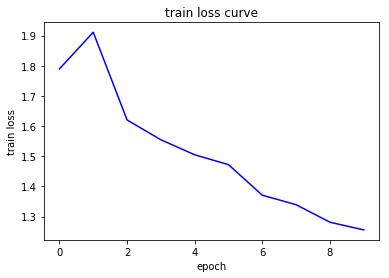

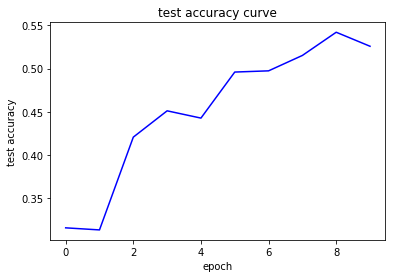

In [30]:
# Hyper-parameters
num_epochs = 10
lr = 0.001
# Device configuration
device = torch.device('cuda:0')
# optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

fit(resnet, num_epochs, optimizer, device)

#### 作业
尝试改变学习率lr,使用SGD或Adam优化器,训练10个epoch,提高ResNet在测试集上的accuracy.

Epoch 1/10:
Step [100/100] Train Loss: 1.6634
Accuracy on Test Set: 31.3400 %
Epoch 2/10:
Step [100/100] Train Loss: 1.7719
Accuracy on Test Set: 34.4600 %
Epoch 3/10:
Step [100/100] Train Loss: 1.7174
Accuracy on Test Set: 39.5800 %
Epoch 4/10:
Step [100/100] Train Loss: 1.7208
Accuracy on Test Set: 39.2000 %
Epoch 5/10:
Step [100/100] Train Loss: 1.5693
Accuracy on Test Set: 38.8600 %
Epoch 6/10:
Step [100/100] Train Loss: 1.4098
Accuracy on Test Set: 48.7600 %
Epoch 7/10:
Step [100/100] Train Loss: 1.1900
Accuracy on Test Set: 49.7800 %
Epoch 8/10:
Step [100/100] Train Loss: 1.3491
Accuracy on Test Set: 47.2400 %
Epoch 9/10:
Step [100/100] Train Loss: 1.3239
Accuracy on Test Set: 52.7000 %
Epoch 10/10:
Step [100/100] Train Loss: 1.1532
Accuracy on Test Set: 55.4800 %


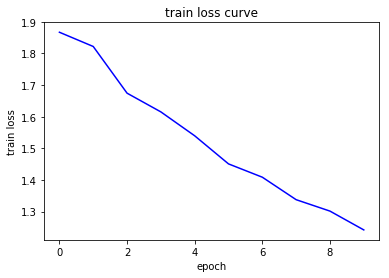

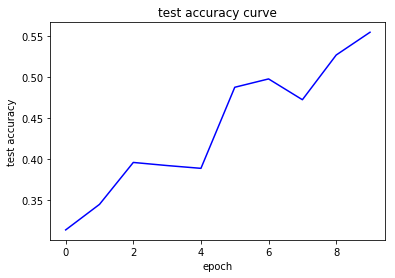

In [32]:
resnet = ResNet(ResidualBlock, [2, 2, 2])
# Hyper-parameters
num_epochs = 10
lr = 0.003
# Device configuration
device = torch.device('cuda:0')
# optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)
# optimizer = torch.optim.SGD(resnet.parameters(), lr=lr, weight_decay=0.01)

fit(resnet, num_epochs, optimizer, device)

#### 作业
下图表示将SE模块嵌入到ResNet的残差模块.
![SE-Resnet module](pics/se-resnet.png)
其中,global pooling表示全局池化层(将输入的size池化为1\*1), 将c\*h\*w的输入变为c\*1\*1的输出.FC表示全连接层(线性层),两层FC之间使用ReLU作为激活函数.通过两层FC后使用sigmoid激活函数激活.最后将得到的c个值与原输入c\*h\*w按channel相乘,得到c\*h\*w的输出.

补充下方的代码完成SE-Resnet block的实现.

In [33]:
from torch import nn


class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        # The output of AdaptiveAvgPool2d is of size H x W, for any input size.
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        """
        To-Do: add code here
        """
        self.fc1 = nn.Linear(channel, channel//reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel//reduction, channel)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        """
        To-Do: add code here
        """
        out = self.avg_pool(x)
        out = out.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), x.size(1), 1, 1)
        out = out*x
        return out

In [34]:
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(SEResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample
        
    def forward(self, x):

        residual = x
        """
        To-Do: add code here
        """
        if self.downsample:
            residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

In [35]:
se_resnet = ResNet(SEResidualBlock, [2, 2, 2])
print(se_resnet)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): SEResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
        (fc1): Linear(in_features=16, out_features=1, bias=True)
        (relu): ReLU(inplace)
        (fc2): Linear(in_features=1, out_features=16, bias=True)
        (sigmoid): Sigmoid()
      )
    )
    (1): SEResidualBlock(
      (conv1): Conv2d(16, 16, kerne

Epoch 1/10:
Step [100/100] Train Loss: 1.8180
Accuracy on Test Set: 33.5400 %
Epoch 2/10:
Step [100/100] Train Loss: 1.7670
Accuracy on Test Set: 31.7800 %
Epoch 3/10:
Step [100/100] Train Loss: 1.4855
Accuracy on Test Set: 43.2000 %
Epoch 4/10:
Step [100/100] Train Loss: 1.4642
Accuracy on Test Set: 40.9000 %
Epoch 5/10:
Step [100/100] Train Loss: 1.3912
Accuracy on Test Set: 45.9600 %
Epoch 6/10:
Step [100/100] Train Loss: 1.3813
Accuracy on Test Set: 48.6200 %
Epoch 7/10:
Step [100/100] Train Loss: 1.3339
Accuracy on Test Set: 52.0600 %
Epoch 8/10:
Step [100/100] Train Loss: 1.3250
Accuracy on Test Set: 52.4800 %
Epoch 9/10:
Step [100/100] Train Loss: 1.1929
Accuracy on Test Set: 53.6600 %
Epoch 10/10:
Step [100/100] Train Loss: 1.0772
Accuracy on Test Set: 56.5600 %


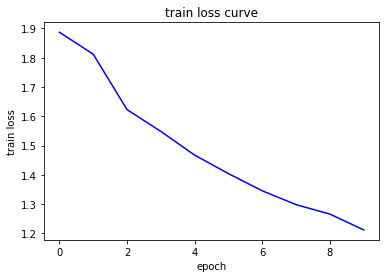

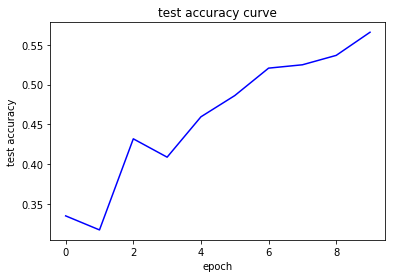

In [36]:
# Hyper-parameters
num_epochs = 10
lr = 0.001
# Device configuration
device = torch.device('cuda:0')
# optimizer
optimizer = torch.optim.Adam(se_resnet.parameters(), lr=lr)

fit(se_resnet, num_epochs, optimizer, device)

### Vgg
接下来让我们阅读vgg网络的实现代码.VGGNet全部使用3\*3的卷积核和2\*2的池化核，通过不断加深网络结构来提升性能。Vgg表明了卷积神经网络的深度增加和小卷积核的使用对网络的最终分类识别效果有很大的作用.
![vgg](pics/vgg_architectures.png)
下面是一份用于训练cifar10的简化版的vgg代码.   
有时间的同学可以阅读并训练它.

In [155]:
import math

class VGG(nn.Module):
    def __init__(self, cfg):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg)
        # linear layer
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        """
        cfg: a list define layers this layer contains
            'M': MaxPool, number: Conv2d(out_channels=number) -> BN -> ReLU
        """
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [156]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
vggnet = VGG(cfg['VGG11'])
print(vggnet)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

Epoch 1/10:
Step [100/100] Train Loss: 1.5574
Accuracy on Test Set: 38.3000 %
Epoch 2/10:
Step [100/100] Train Loss: 1.5747
Accuracy on Test Set: 42.5200 %
Epoch 3/10:
Step [100/100] Train Loss: 1.4515
Accuracy on Test Set: 47.1400 %
Epoch 4/10:
Step [100/100] Train Loss: 1.2517
Accuracy on Test Set: 54.4800 %
Epoch 5/10:
Step [100/100] Train Loss: 1.2734
Accuracy on Test Set: 54.7400 %
Epoch 6/10:
Step [100/100] Train Loss: 1.1642
Accuracy on Test Set: 59.9600 %
Epoch 7/10:
Step [100/100] Train Loss: 1.0123
Accuracy on Test Set: 61.4800 %
Epoch 8/10:
Step [100/100] Train Loss: 1.1231
Accuracy on Test Set: 62.5000 %
Epoch 9/10:
Step [100/100] Train Loss: 1.1146
Accuracy on Test Set: 63.9800 %
Epoch 10/10:
Step [100/100] Train Loss: 0.7537
Accuracy on Test Set: 66.9800 %


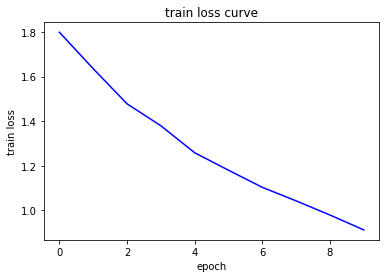

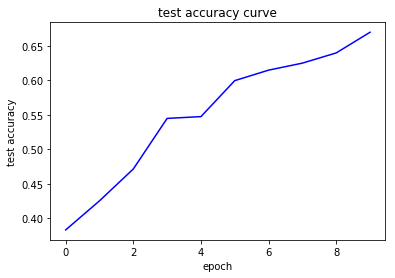

In [157]:
# Hyper-parameters
num_epochs = 10
lr = 1e-3
# Device configuration
device = torch.device('cuda:0')

# optimizer
optimizer = torch.optim.Adam(vggnet.parameters(), lr=lr)

fit(vggnet, num_epochs, optimizer, device)